In [ ]:
import os
import numpy as np

import analysis_plotting_helper_functions_c3v3 as helper
import session_processing_helper_c5 as processing_helper
import utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
cohort = "cohort_5+6"
data_folder = os.path.join(data_dir, exp, cohort)
figure_folder = os.path.join(data_dir, exp, f'{cohort}_figures')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/data/behavior_data/exp2/cohort_5+6
/Users/rebekahzhang/data/behavior_data/exp2/cohort_5+6_figures


In [3]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

In [4]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7", "#96c3d6", "#c4d7a7", "#d1b9d9",
          "#ffcc00"]

# Merge session logs of cohort 5 and cohort 6
merging two logs and adding training session number, then saving. remember to move data from cohort folders to combined folder. Does not need to be re run

In [5]:
sessions_c5 = pd.read_csv(os.path.join(data_dir, exp, 'cohort_5', 'sessions_training.csv'))
sessions_c6 = pd.read_csv(os.path.join(data_dir, exp, 'cohort_6', 'sessions_training.csv'))

In [6]:
sessions_c5c6 = pd.concat([sessions_c5, sessions_c6])

In [7]:
sessions_c5c6 = sessions_c5c6.drop(columns = ['Unnamed: 0'])
sessions_c5c6 = sessions_c5c6.groupby('mouse', group_keys=False).apply(processing_helper.assign_session_numbers)

In [8]:
sessions_c5c6 = sessions_c5c6.groupby('mouse', group_keys=False).apply(processing_helper.assign_session_numbers)
sessions_c5c6 = sessions_c5c6.sort_values('dir')

In [9]:
utils.save_log(sessions_c5c6, data_folder, "sessions_training.csv")

# Session based plotting

### load session log

In [51]:
sessions_training = pd.read_csv(os.path.join(data_folder, 'sessions_training.csv'))

### make mouse list

In [52]:
# mouse_list = utils.generate_mouse_list(sessions_training)
mouse_list = ['RZ034', 'RZ036', 'RZ037', 'RZ038', 'RZ039', 'RZ047', 'RZ050', 'RZ051', 'RZ052', 'RZ053', 'RZ054', 'RZ055', 'RZ056']
print(mouse_list)

['RZ034', 'RZ036', 'RZ037', 'RZ038', 'RZ039', 'RZ047', 'RZ050', 'RZ051', 'RZ052', 'RZ053', 'RZ054', 'RZ055', 'RZ056']


In [53]:
cohort_group = {"s": ['RZ034', 'RZ036', 'RZ047', 'RZ050', 'RZ051'], 
                "l": ['RZ037', 'RZ038', 'RZ039', 'RZ052', 'RZ053', 'RZ054', 'RZ055', 'RZ056']}

### finalizing data set before plotting

In [54]:
sessions_training = sessions_training.loc[sessions_training['session'] <= 57]

In [86]:
sessions_training = sessions_training.loc[sessions_training['mouse']!= 'RZ049']

In [87]:
sessions_training = sessions_training.loc[~sessions_training['mouse'].isin(['RZ049', 'RZ038'])]

### Plotting functions
should be moved to helper

In [15]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session, session_mouse[column_name], color=colors[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [16]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session",
                 y=column_name,
                 hue="group",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.ylim(1,4)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [ ]:
sessions_training

In [90]:
def generate_trial_type_df(training_session_log):
    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == session_info['dir'], 
                                    ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'group', 'session', 'num_trials', 
                                            'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [91]:
trial_type_df = generate_trial_type_df(sessions_training)

### trial type combined plot

In [ ]:
for group, mice in cohort_group.items():
  fig, axs = plt.subplots(8, 1, figsize=(10, 10), sharex=True)

  for i, mouse in enumerate(mice):
    session_mouse = trial_type_df.loc[(trial_type_df.mouse == mouse) & (trial_type_df.group == group)]
    to_plot = session_mouse.loc[:, ['session', 'p_good', 'p_miss', 'p_accident']]
    ax = axs.flat[i]
    to_plot.plot.bar(x='session', stacked=True, ax=ax, legend=None)
    ax.set_title(mouse)
    ax.set_xlabel('Sessions')
    ax.set_ylabel('Normalized Proportion')
    ax.plot(to_plot.session, to_plot.p_good, color='k', linewidth=1.5)
  
  # if group == "l":
  #   handles, labels = ax.get_legend_handles_labels()
  #   fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
  # if group == "s" and len(mice) < 5:
  #   axs.flat[-1].axis('off')
  plt.tight_layout()
  plt.savefig(f'{figure_folder}/engagement_plots_{group}.png', bbox_inches='tight')

### percentage good trials

In [ ]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent missed trials

In [ ]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent accident trials

In [ ]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [99]:
def generate_reward_df(sessions):

    reward_df = sessions[['mouse', 'group', 'session', 'num_trials', 
                                            'rewards', 'session_time']].copy()
    reward_df['reward_rate'] = reward_df.rewards/reward_df.session_time
    reward_df['reward_per_trial'] = reward_df.rewards/reward_df.num_trials
    reward_df['num_trials_rewarded'] = reward_df.rewards/5
    reward_df['%_trials_rewarded'] = reward_df.num_trials_rewarded/reward_df.num_trials

    return reward_df

In [100]:
rewards_df = generate_reward_df(sessions_training)

### plot % rewarded trials

In [ ]:
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='%_trials_rewarded', 
                         plot_name="%_trials_rewarded",
                         title='Percent Trials Rewarded', 
                         x_label='Sessions', 
                         y_label='%')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="%_trials_rewarded", 
                               plot_name='%_trials_rewarded_by_group', 
                               title='Percent Trials Rewarded', 
                               x_label='Sessions', 
                               y_label='%')

### Plot reward rate

In [ ]:
# plot the reward rate
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Sessions', 
                         y_label='Reward Rate (ul/s)')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Sessions', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

In [ ]:
# plot the session length
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='session_time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Sessions', 
                         y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="session_time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Sessions', 
                               y_label='Time (s)')

### plot num trials completed

In [ ]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Sessions', 
                         y_label='Count')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Sessions', 
                               y_label='Count')

# Plot background behavior

### generate mistake df for plotting

In [109]:
def get_session_mistakes(all_trials):
    all_trials['bg_repeats'] -= 1
    num_bg_repeats_mean = all_trials.bg_repeats.mean()
    num_bg_repeats_med = all_trials.bg_repeats.median()
    num_bg_repeats_std = all_trials.bg_repeats.std()
    num_bg_repeats_rate_mean = num_bg_repeats_mean/all_trials.bg_length.mean()
    return [num_bg_repeats_mean, num_bg_repeats_med, num_bg_repeats_std, num_bg_repeats_rate_mean]

In [110]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_mistakes = get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == session_info['dir'], 
                                ['num_bg_repeats_mean', 'num_bg_repeats_med', 
                                 'num_bg_repeats_std', 'num_bg_repeats_rate_mean']] = session_mistakes
    return mistake_df

In [111]:
mistakes_df = generate_mistake_df(sessions_training)

### plot number of mistakes per trial

In [ ]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_mean', 
                         plot_name="num_bg_repeats_mean", 
                         title='Number of Background Repeat Penalty',
                         x_label='Sessions', 
                         y_label=' ')

In [ ]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_mean", 
                               plot_name='num_bg_repeats_mean_by_group', 
                               title='Number of Background Repeat Penalty', 
                               x_label='Sessions', 
                               y_label=' ')

### plot mistake rate

In [ ]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_rate_mean', 
                         plot_name="num_bg_repeats_rate_mean", 
                         title='Background Repeat Rate',
                         x_label='Sessions', 
                         y_label='Count per Second')

In [ ]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_rate_mean", 
                               plot_name='num_bg_repeats_rate_mean_by_group', 
                               title='Background Repeat Rate', 
                               x_label='Sessions', 
                               y_label='Count per Second')

# Plot time wait behavior

### generate wait df for plotting

In [15]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [88]:
wait_df = generate_wait_df(sessions_training)

### plot time watied

In [ ]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean', 
                         plot_name="tw_mean", 
                         title='Time Waited',
                         x_label='Sessions', 
                         y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Sessions', 
                               y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df_no_outlier, 
                               column_name="tw_mean", 
                               plot_name='tw_mean_by_group', 
                               title='Time Waited', 
                               x_label='Sessions', 
                               y_label='Time (s)')

In [ ]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Sessions', 
                         y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions', 
                               y_label='Time (s)')

## some stats

all sessions tw difference

In [89]:
wait_df

,mouse,session,dir,group,tw_mean,tw_median,tw_stdev,tw_mean_g,tw_median_g,tw_stdev_g
0,RZ034,0,2024-01-30_09-52-34_RZ034,s,0.466963,0.340259,0.435522,0.431781,0.310554,0.390514
1,RZ036,0,2024-01-30_09-55-23_RZ036,s,0.390074,0.302142,0.332347,0.378059,0.232625,0.395064
2,RZ037,0,2024-01-30_10-36-04_RZ037,l,1.696422,0.789636,2.564594,2.390402,1.037323,3.418212
4,RZ039,0,2024-01-30_11-40-20_RZ039,l,1.179677,0.509508,1.559682,2.174182,1.180063,1.941666
5,RZ034,1,2024-01-31_10-37-51_RZ034,s,2.447444,1.334782,3.606793,3.078756,1.523699,4.509924
...,...,...,...,...,...,...,...,...,...,...
1011,RZ052,57,2024-09-13_11-47-24_RZ052,l,2.596680,1.463440,4.208879,3.678163,2.085946,5.827187
1012,RZ053,57,2024-09-13_12-16-00_RZ053,l,1.980068,1.221629,4.397515,2.546296,1.195273,6.384118
1013,RZ054,57,2024-09-13_12-21-28_RZ054,l,2.140448,0.831807,5.515733,3.638768,1.050284,7.904301
1014,RZ055,57,2024-09-13_12-23-39_RZ055,l,4.832807,1.941313,8.890270,7.841885,3.168195,11.293142


In [90]:
wait_by_mouse = wait_df.groupby('mouse')
for m, mouse_data in wait_by_mouse:
    avg_avg_tw = mouse_data['tw_mean'].mean()
    print(m, "avg tw:", avg_avg_tw)

RZ034 avg tw: 1.7321099594691909
RZ036 avg tw: 2.121853089809856
RZ037 avg tw: 3.887343703496214
RZ039 avg tw: 5.558478202124927
RZ047 avg tw: 2.26219010828616
RZ048 avg tw: 1.7774260335827543
RZ050 avg tw: 2.2476466916241535
RZ051 avg tw: 2.2411428607987665
RZ052 avg tw: 2.739564537204516
RZ053 avg tw: 2.9562906624903658
RZ054 avg tw: 5.112327289732677
RZ055 avg tw: 5.219981593361283
RZ056 avg tw: 2.376790463573562


### zscore outlier

In [91]:
def calculate_tw_z_score(mouse_data):
    time_waited = mouse_data['tw_mean']
    z_score = stats.zscore(time_waited)
    mouse_data['tw_z_score'] = z_score
    return mouse_data

In [92]:
wait_df = wait_df.groupby('mouse', group_keys=False).apply(calculate_tw_z_score)

In [93]:
outlier_sessions = wait_df[(wait_df['tw_z_score'] > 3) | (wait_df['tw_z_score'] < -3)]

In [95]:
wait_df_no_outlier = wait_df[wait_df['tw_z_score'].between(-3, 3)]

In [96]:
wait_df_no_outlier

,mouse,session,dir,group,tw_mean,tw_median,tw_stdev,tw_mean_g,tw_median_g,tw_stdev_g,tw_z_score
0,RZ034,0,2024-01-30_09-52-34_RZ034,s,0.466963,0.340259,0.435522,0.431781,0.310554,0.390514,-1.578426
1,RZ036,0,2024-01-30_09-55-23_RZ036,s,0.390074,0.302142,0.332347,0.378059,0.232625,0.395064,-1.443811
2,RZ037,0,2024-01-30_10-36-04_RZ037,l,1.696422,0.789636,2.564594,2.390402,1.037323,3.418212,-0.986132
4,RZ039,0,2024-01-30_11-40-20_RZ039,l,1.179677,0.509508,1.559682,2.174182,1.180063,1.941666,-1.235899
5,RZ034,1,2024-01-31_10-37-51_RZ034,s,2.447444,1.334782,3.606793,3.078756,1.523699,4.509924,0.892467
...,...,...,...,...,...,...,...,...,...,...,...
1011,RZ052,57,2024-09-13_11-47-24_RZ052,l,2.596680,1.463440,4.208879,3.678163,2.085946,5.827187,-0.094179
1012,RZ053,57,2024-09-13_12-16-00_RZ053,l,1.980068,1.221629,4.397515,2.546296,1.195273,6.384118,-0.726359
1013,RZ054,57,2024-09-13_12-21-28_RZ054,l,2.140448,0.831807,5.515733,3.638768,1.050284,7.904301,-0.884566
1014,RZ055,57,2024-09-13_12-23-39_RZ055,l,4.832807,1.941313,8.890270,7.841885,3.168195,11.293142,-0.117164


### within group anova

In [114]:
short = wait_df_no_outlier[wait_df_no_outlier['group']=='s']
long = wait_df_no_outlier[wait_df_no_outlier['group']=='l']

In [115]:
short_by_mouse = short.groupby('mouse')
mouse_names = short.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [short_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(short['tw_mean'], short['mouse'])
print(tukey_results)

F-stats: 1.6420756956404134
P-value: 0.1488716654029924
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 RZ034  RZ036   0.3382 0.3754   -0.16 0.8364  False
 RZ034  RZ047   0.4463  0.108 -0.0518 0.9445  False
 RZ034  RZ048   0.0919 0.9999 -0.9732 1.1571  False
 RZ034  RZ050   0.3447 0.3533 -0.1535 0.8429  False
 RZ034  RZ051   0.1904 0.8864 -0.3123 0.6931  False
 RZ036  RZ047   0.1082 0.9893   -0.39 0.6063  False
 RZ036  RZ048  -0.2463 0.9857 -1.3114 0.8189  False
 RZ036  RZ050   0.0065    1.0 -0.4916 0.5047  False
 RZ036  RZ051  -0.1478  0.959 -0.6505 0.3549  False
 RZ047  RZ048  -0.3544 0.9316 -1.4196 0.7107  False
 RZ047  RZ050  -0.1016 0.9919 -0.5998 0.3965  False
 RZ047  RZ051   -0.256 0.6894 -0.7586 0.2467  False
 RZ048  RZ050   0.2528 0.9839 -0.8124 1.3179  False
 RZ048  RZ051   0.0985 0.9998 -0.9688 1.1657  False
 RZ050  RZ051  -0.1543 0.9509  -0.657 0.3484  False
--------

In [116]:
long_by_mouse = long.groupby('mouse')
mouse_names = long.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [long_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(long['tw_mean'], long['mouse'])
print(tukey_results)

F-stats: 19.08943927105315
P-value: 1.5859334792570996e-19
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 RZ037  RZ039   1.8049 0.0004  0.5744  3.0354   True
 RZ037  RZ052  -1.1315 0.0976 -2.3673  0.1043  False
 RZ037  RZ053  -0.9712 0.2376 -2.2125  0.2701  False
 RZ037  RZ054   1.1815 0.0715 -0.0543  2.4174  False
 RZ037  RZ055    0.986 0.2213 -0.2554  2.2273  False
 RZ037  RZ056  -1.4537 0.0097 -2.6895 -0.2178   True
 RZ039  RZ052  -2.9364    0.0 -4.1668 -1.7059   True
 RZ039  RZ053  -2.7761    0.0 -4.0121 -1.5401   True
 RZ039  RZ054  -0.6233  0.744 -1.8538  0.6071  False
 RZ039  RZ055  -0.8189 0.4397 -2.0549  0.4171  False
 RZ039  RZ056  -3.2585    0.0  -4.489 -2.0281   True
 RZ052  RZ053   0.1603 0.9998  -1.081  1.4016  False
 RZ052  RZ054    2.313    0.0  1.0772  3.5488   True
 RZ052  RZ055   2.1174    0.0  0.8761  3.3588   True
 RZ052  RZ056  -0.3222 0.9874  -1.558  0

### between group t_test

In [117]:
short = wait_df[wait_df['group']=='s']
long = wait_df[wait_df['group']=='l']

print(short.tw_mean.mean())
print(long.tw_mean.mean())
print()

#perform independent two sample t-test
stats.ttest_ind(short['tw_mean'], long['tw_mean'])

2.1128911091393623
3.9786823502833637



Ttest_indResult(statistic=-10.422406575854321, pvalue=9.584355564436378e-24)

In [118]:
short = wait_df_no_outlier[wait_df_no_outlier['group']=='s']
long = wait_df_no_outlier[wait_df_no_outlier['group']=='l']

print(short.tw_mean.mean())
print(long.tw_mean.mean())

#perform independent two sample t-test
stats.ttest_ind(short['tw_mean'], long['tw_mean'])

1.9457771597014173
3.8176802165884003


Ttest_indResult(statistic=-12.09599332128395, pvalue=1.1456236330093193e-30)

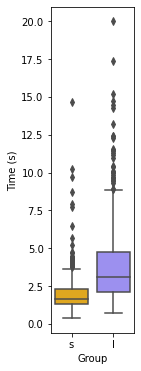

In [110]:
plt.figure(figsize=(1.5, 6))
sns.boxplot(data=wait_df, x="group", y="tw_mean", palette=custom_palette)
plt.ylabel("Time (s)")
plt.xlabel("Group")
plt.savefig(f'{figure_folder}/{"tw_box"}.png', bbox_inches='tight')

by days sessions tw difference

In [111]:
def generate_p_val_df(wait_df, group_col_name):
    result_list = []
    for num, data in wait_df.groupby(group_col_name):
        short = data[data['group']=='s']
        long = data[data['group']=='l']
        s_tw = short.tw_mean.mean()
        l_tw = long.tw_mean.mean()

        # Perform t-test
        ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
        p_val_t = ttest[1]

        # Perform Mann-Whitney U test
        u_test = stats.mannwhitneyu(short['tw_mean'], long['tw_mean'])
        p_val_u = u_test[1]

        result_list.append([num, s_tw, l_tw, p_val_t, p_val_u])

    return pd.DataFrame(result_list, columns=["num", "s_tw", "l_tw", "p_val_t", "p_val_u"])

plot waiting df in 10 day intervals

In [112]:
wait_df['period'] = wait_df['session']//10 #add session period in 10 day intervals

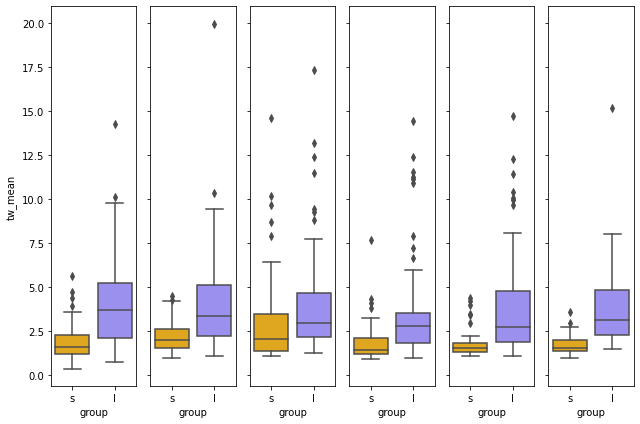

In [113]:
num_subplots = wait_df['period'].max()+1
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*1.5, 6), sharey=True)
for p, period_data in wait_df.groupby('period'):
    sns.boxplot(data=period_data,
                x="group", 
                y="tw_mean", 
                palette=custom_palette,
                ax=axs.flat[p])
    if p != 0:
        axs.flat[p].set_ylabel("")

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_box_by_period.png', bbox_inches='tight')

In [ ]:
tw_stats_by_period = generate_p_val_df(wait_df, "period")
tw_stats_by_period[tw_stats_by_period['p_val_t'] < 0.05]

In [ ]:
tw_stats_by_period

## plots to be figured out

In [ ]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean, session_mouse.tw_stdev, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[3].axis('off')
        axs.flat[4].axis('off')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_plots_{group}.png', bbox_inches='tight', dpi=300)

In [ ]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median_g, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[2].axis('off')
        # axs.set_ylim(0, 35)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_good_plots_{group}.png', bbox_inches='tight', dpi=300)

In [58]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [59]:
for mouse in mouse_list:
    session_mouse = sessions_training.loc[sessions_training.mouse == mouse]
    num_rows, num_cols = calculate_subplot_row_col(session_mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(21.5, 2.5 * num_rows))

    for i, (_, session_info) in enumerate(session_mouse.iterrows()):
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="group",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_ylim([0,35])
        ax.set_title(f'Session {i}')
        ax.legend().remove()
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)
    plt.close()

# Stitched all sessions all mice per day

In [ ]:
stitched_folder = os.path.join(data_dir, cohort, exp, 'stitched')
stitched_figure_folder = os.path.join(data_dir, cohort, exp, 'figures')
print(data_folder)
print(figure_folder)

In [61]:
stitched_log = utils.load_session_log(stitched_folder, f'sessions_training_stitched_{exp}.csv')

In [62]:
def generate_events_processed_stitched_path(data_folder, session_info):
    filename = f'events_processed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, f"{session_info.date}", filename)

In [63]:
def generate_trials_analyzed_stitched_path(data_folder, session_info):
    filename = f'trials_analyzed_stitched_{session_info.date}.csv'
    return os.path.join(data_folder, session_info.date, filename)

In [ ]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_kde.png', bbox_inches='tight', dpi=300)

In [ ]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=all_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=all_trials.loc[all_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=all_trials.loc[all_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')
    
# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_cdf.png', bbox_inches='tight', dpi=300)

In [66]:
def select_non_accident_trials(all_trials):
    non_accident_trials = all_trials[all_trials['time_waited'] > 0.5]
    return non_accident_trials

In [ ]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.kdeplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 0.6])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_kde.png', bbox_inches='tight', dpi=300)

In [ ]:
days_trained = len(stitched_log)
num_rows = (days_trained - 1) // 10 + 1
num_cols = min(days_trained, 10)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(2.5*num_cols, 2.5 * num_rows))

for i, (_, session_info) in enumerate(stitched_log.iterrows()):
    all_trials = utils.load_data(generate_trials_analyzed_stitched_path(stitched_folder, session_info))
    non_accident_trials = select_non_accident_trials(all_trials)
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axs[row_idx, col_idx]

    sns.ecdfplot(data=non_accident_trials.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette,
                    ax=axs.flat[i])
    
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
    ax.axvline(x=non_accident_trials.loc[non_accident_trials.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
    
    ax.set_xlim([0, 15])
    ax.set_ylim([0, 1.01])
    
    ax.set_title(f'Session {i+1}')

# Remove any unused subplots
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        axs.flat[j].axis('off')

for i in range(days_trained):
    ax = axs.flat[i]
    ax.get_legend().remove()

# Adjust the spacing between subplots
plt.tight_layout()

# Save the figure with proper spacing around the subplots
plt.savefig(f'{stitched_figure_folder}/tw_g_cdf.png', bbox_inches='tight', dpi=300)